In [1]:
# Connect API Kaggle
from google.colab import files
files.upload()
!ls -lha kaggle.json
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
-rw-r--r-- 1 root root 71 May 31 10:07 kaggle.json


In [2]:
# API dataset Alzheimer's Dataset ( 4 class of Images)
!kaggle datasets download -d tourist55/alzheimers-dataset-4-class-of-images

 91% 31.0M/34.1M [00:00<00:00, 160MB/s] 
100% 34.1M/34.1M [00:00<00:00, 151MB/s]


In [3]:
# Unzip file
!unzip alzheimers-dataset-4-class-of-images.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem207.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem208.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem209.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem21.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem210.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem211.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem212.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem213.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem214.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem215.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem216.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem217.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem218.jpg  
  inflating: Alzheimer_s Dataset/train/MildDe

In [5]:
# Import library
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Flatten, Dense, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [6]:
# Data Pre-processing
train_data_dir = "Alzheimer_s Dataset/train/"
test_data_dir = "Alzheimer_s Dataset/test/"

# Parameter
image_size = (150, 150)
batch_size = 64
lr = 0.0001
num_epochs = 55

In [7]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=30,
    width_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

# Pass in the appropriate arguments to the flow method
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    target_size=image_size)  

# Validation data should not be augmented
validation_datagen = ImageDataGenerator(rescale = 1./255.)
validation_generator =  validation_datagen.flow_from_directory(test_data_dir,
                                                               batch_size=batch_size,
                                                               shuffle=True,
                                                               class_mode='categorical',
                                                               target_size=image_size)

Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


**MobileNetV2**

In [8]:
# Define model architecture
pre_trained_model = MobileNetV2(
    include_top=False,
    weights='imagenet',
    # input_tensor=Input(shape=(150, 150, 3)
    input_shape=(150,150,3)
)

for layer in pre_trained_model.layers:
    layer.trainable = False

x = pre_trained_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
# x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=pre_trained_model.input, outputs=predictions)

# Compile the model
optimizer = Adam(learning_rate=lr)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

9406464/9406464 [==============================] - 0s 0us/step


In [9]:
# Define the callback
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.85 and logs.get('val_accuracy') > 0.85:
            print("\nReached 85% accuracy, stopping training!")
            self.model.stop_training = True

callbacks = myCallback()

In [10]:
# Train the model
history = model.fit(
    train_generator,
    epochs=num_epochs,
    validation_data=validation_generator,
    callbacks=[callbacks]
)

Epoch 1/55
81/81 [==============================] - 50s 417ms/step - loss: 2.7852 - accuracy: 0.3546 - val_loss: 2.5363 - val_accuracy: 0.2909
Epoch 2/55
81/81 [==============================] - 29s 362ms/step - loss: 2.5171 - accuracy: 0.4232 - val_loss: 2.3023 - val_accuracy: 0.4871
Epoch 3/55
81/81 [==============================] - 31s 389ms/step - loss: 2.3918 - accuracy: 0.4714 - val_loss: 2.2126 - val_accuracy: 0.5442
Epoch 4/55
81/81 [==============================] - 33s 404ms/step - loss: 2.3002 - accuracy: 0.4950 - val_loss: 2.2264 - val_accuracy: 0.5410
Epoch 5/55
81/81 [==============================] - 30s 364ms/step - loss: 2.2250 - accuracy: 0.5282 - val_loss: 2.1380 - val_accuracy: 0.5739
Epoch 6/55
81/81 [==============================] - 30s 365ms/step - loss: 2.1694 - accuracy: 0.5513 - val_loss: 2.1191 - val_accuracy: 0.5661
Epoch 7/55
81/81 [==============================] - 31s 376ms/step - loss: 2.1186 - accuracy: 0.5583 - val_loss: 2.1046 - val_accuracy: 0.5614

In [11]:
import tensorflow as tf
import pandas as pd
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab import files

<function matplotlib.pyplot.show(close=None, block=None)>

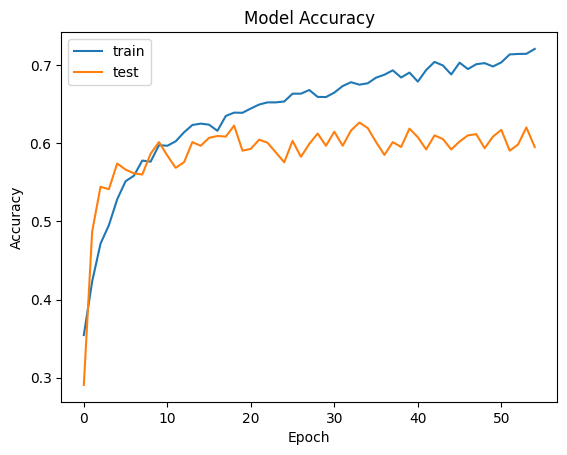

In [12]:
#Plot Akurasi
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train','test'], loc='upper left')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

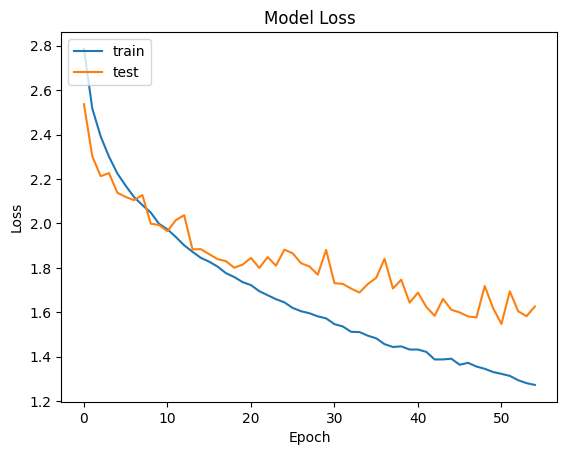

In [13]:
#Plot Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train','test'], loc='upper left')
plt.show

In [14]:
# export_dir = 'saved_model/'
# tf.saved_model.save(model, export_dir)
 
# converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
# tflite_model = converter.convert()
 
# tflite_model_file = pathlib.Path('alzheimers.tflite')
# tflite_model_file.write_bytes(tflite_model)

In [15]:
# Download file model JSON
json_model_path = "model_Alzheimer.json"
json_data = model.to_json()
with open(json_model_path, "w") as json_file:
    json_file.write(json_data)

files.download(json_model_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>